In [1]:
%matplotlib inline

# Scientific computing
import numpy as np
import pandas as pd
from scipy import interp

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#sns.set_context('paper')

# Machine Learning
# Model
from sklearn.svm import SVC
# Ensemble model
from sklearn.ensemble import BaggingClassifier
# Splitter Classes
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
# Splitter Functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
# Model validation
from sklearn.model_selection import learning_curve
# Training metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Other
import requests
import threading

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
first_cycle = True
with pd.HDFStore('../../classification/ris/OUT-classified-merged.h5', mode='r') as in_data:
    for group in ['GLITCH', 'NO_GLITCH']:
        if first_cycle == True:
            data = np.array(in_data[group].to_numpy())
            if group == 'GLITCH':
                target = np.ones(len(data))
            elif group == 'NO_GLITCH':
                target = np.zeros(len(data))
            else:
                print("ERROR.")
            first_cycle = False
        else:
            data = np.concatenate((data, in_data[group].to_numpy()))
            if group == 'GLITCH':
                target = np.concatenate((target, np.ones(len(in_data[group].to_numpy()))))
            elif group == 'NO_GLITCH':
                target = np.concatenate((target, np.zeros(len(in_data[group].to_numpy()))))
            else:
                print("ERROR.")
    data = np.concatenate((data, in_data['MULTI_GLITCH'].to_numpy()))
    target = np.concatenate((target, np.ones(len(in_data['MULTI_GLITCH'].to_numpy()))))

In [8]:
results = []

data.sort(axis=1)

kernel_list = ['linear']
#gamma_list = np.arange(0.02, 0.03, 0.001)
gamma_list = [1]
C_list = np.arange(0.05, 1, 0.05)

# Multithreading
maxthreads = 8
sema = threading.Semaphore(value=maxthreads)
c = threading.Condition()

k = 0

# Multithread function
def cm_th(kernel, gamma, C):
    sema.acquire()
    global data
    global target
    global cm
    clf = SVC(kernel=kernel, gamma=gamma, C=C)
    c.acquire()
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=None, stratify=target)
    c.notify_all()
    c.release()
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    labels = [0., 1.]
    #labels_text = ['no glitch', 'glitch']
    cm_loc = confusion_matrix(y_test, y_pred, labels=labels)
    c.acquire()
    cm = np.append(cm, cm_loc[1,0])
    c.notify_all()
    c.release()
    sema.release()

# k-fold parameters
n_splits = 5
n_repeats = 6

# Multithread function
def sc_th(kernel, gamma, C, train_index, test_index):
    # Acquire a semaphore slot
    sema.acquire()
    # Set global variables
    global data
    global target
    global scores
    # Load training and testing data
    c.acquire()
    clf = SVC(kernel=kernel, gamma=gamma, C=C)
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = target[train_index], target[test_index]
    c.notify_all()
    c.release()
    # Fit the model
    clf.fit(X_train, y_train)
    train_score = clf.score(X_test, y_test)
    # Save the score
    c.acquire()
    scores = np.append(scores, train_score)
    c.notify_all()
    c.release()
    # Release the semaphore slot
    sema.release()

k = 0
for kernel in kernel_list:
    for gamma in gamma_list:
        for C in C_list:
            
            # Confusion matrix
            cm = np.array([])
            threads = []
            for i in range(20):
                thread = threading.Thread(target=cm_th, args=(kernel, gamma, C))
                threads.append(thread)
                thread.start()
            for thread in threads:
                thread.join()
            
            # Stratified k-fold
            rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
            scores = np.array([])
            threads = []
            # Make k-fold CV
            for train_index, test_index in rskf.split(data, target):
                thread = threading.Thread(target=sc_th, args=(kernel, gamma, C, train_index, test_index))
                threads.append(thread)
                thread.start()
            for thread in threads:
                thread.join()
                
            # Save
            results.append(str(cm.mean()) + ', ' + str(cm.std()) + ', ' + str(scores.mean()) + ',' + str(kernel) + ', ' + str(gamma) + ', ' + str(C))
            k += 1
            print('status:', str(k) + '/' + str(len(kernel_list)*len(gamma_list)*len(C_list)), '\r', end='')

In [9]:
with open('risultati_s', mode='w') as f:
    for i in results:
        print(i, file=f)

In [18]:
best_kernel = 'linear'
best_gamma = 0.024
best_C = 0.20

In [4]:
data.sort(axis=1)

In [19]:
# Multithreading
maxthreads = 8
sema = threading.Semaphore(value=maxthreads)
c = threading.Condition()

# k-fold parameters
n_splits = 5
n_repeats = 50

# Multithread function
def thread_function(train_index, test_index):
    # Acquire a semaphore slot
    sema.acquire()
    # Set global variables
    global data
    global target
    global scores
    global best_kernel
    global best_gamma
    global best_C
    # Load training and testing data
    c.acquire()
    clf = SVC(kernel=best_kernel, gamma=best_gamma, C=best_C)
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = target[train_index], target[test_index]
    c.notify_all()
    c.release()
    # Fit the model
    clf.fit(X_train, y_train)
    train_score = clf.score(X_test, y_test)
    # Save the score
    c.acquire()
    scores = np.append(scores, train_score)
    c.notify_all()
    c.release()
    # Release the semaphore slot
    sema.release()

# Stratified k-fold
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)
scores = np.array([])
threads = []
# Make k-fold CV
for train_index, test_index in rskf.split(data, target):
    thread = threading.Thread(target=thread_function, args=(train_index, test_index))
    threads.append(thread)
    thread.start()
for thread in threads:
    thread.join()
    
# Print final score
print('Score:', scores.mean(), '+-', scores.std())

Score: 0.9993398978743616 +- 0.001309689565871446


[[29499     1]
 [   42 30458]]


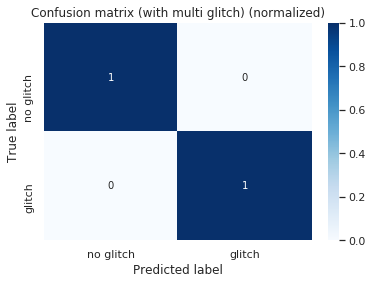

In [21]:
clf = SVC(kernel=best_kernel, gamma=best_gamma, C=best_C)

def plot_confusion_matrix(cm, labels, title, filename, normalize=True, save=True):
    # Create DataFrame
    df_cm = pd.DataFrame(cm, columns=labels, index=labels)
    df_cm.index.name = 'True label'
    df_cm.columns.name = 'Predicted label'
    
    # Normalize
    if normalize:
        df_cm = df_cm.div(df_cm.sum(axis=1), axis=0).round(decimals=2)
    
    # Plot
    fig, ax = plt.subplots()
    ax = sns.heatmap(df_cm, cmap='Blues', annot=True)
    axlim = ax.get_ylim()
    ax.set_ylim(axlim[0] + 0.5, axlim[1] - 0.5)
    if normalize:
        ax.set_title(title + ' (normalized)')
    else:
        ax.set_title(title)

cm = np.zeros(shape=(2,2), dtype=int)
# Compute the average confusion matrix
for i in range(100):
    print (i, '\r', end='')
    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=None, stratify=target)
    # Train and predict
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    # Compute confusion matrix
    labels = [0., 1.]
    labels_text = ['no glitch', 'glitch']
    cm += confusion_matrix(y_test, y_pred, labels=labels)
print(cm)
plot_confusion_matrix(cm, labels_text, 'Confusion matrix (with multi glitch)', 'ris/plots/mg-confusion_matrix.pdf', normalize=True)